In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import scipy.signal as signal
from mpl_toolkits.mplot3d import Axes3D
import time

In [3]:
''' taylorF2 model'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return m1,m2
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
def F_cross(theta,psi,phi):
    return 0.5*(1+np.power(np.cos(theta),2))*np.cos(2*phi)*np.sin(2*psi)-np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)
def F_plus(theta,psi,phi):
    return -0.5*(1+np.power(np.cos(theta),2))*np.cos(2.0*phi)*np.cos(2*psi)-np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
def D_eff(D,theta,psi,phi,iota):
    return D/(np.sqrt(np.power(F_cross(theta,psi,phi),2.0)*np.power(np.cos(iota),2.0)+np.power(F_plus(theta,psi,phi),2)*0.25*(1+np.power(np.cos(iota),2))))
def Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c,v_lso=1/np.sqrt(6.0)):
    Mcal=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal*f,1/3.0)
    return 2*sciconsts.pi*f*t_c-phi_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v/v_lso))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c):
    return np.power(m_c,5.0/6.0)/D_eff(D,theta,psi,phi,iota)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c))
def Psi2(f,m_c,smr,t_c):
    Mcal2=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal2*f,1/3.0)
    return 2*sciconsts.c*f*t_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v*np.sqrt(6.0)))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h_mod(f,m_c,smr,t_c):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi2(f,m_c,smr,t_c))*1e-48
def Psi3(f,m_c,smr):
    Mcal2=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal2*f,1/3.0)
    return -sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v*np.sqrt(6.0)))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h_mod2(f,m_c,smr):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi3(f,m_c,smr))*1e-48

'''my Tmodel(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)/1e70
'''my Tmode not considering gas'''
def acalvac(t,k_1,t_c):
    return np.power(4*k_1*(t_c-t),0.25)
def freq_tvac(t,m_1,m_2,t_c):
    avt=acalvac(t,k_1cal(m_1,m_2),t_c)
    return np.sqrt(sciconsts.G*(m_1+m_2))/sciconsts.pi*np.power(avt,-1.5)
def phi_tvac(t,m_1,m_2,t_c):
    cm2=chirp_mass(m_1,m_2)
    return -2*np.power(np.power(sciconsts.c,3.0)/5.0/cm2/sciconsts.G*(t_c-t),5.0/8.0)
def hvac(t,m_1,m_2,t_c,phi_c):
    return  m_1*m_2/acalvac(t,k_1cal(m_1,m_2),t_c)*np.cos(phi_tvac(t,m_1,m_2,t_c)+phi_c)/1e70
#phi_c[0,2pi]
def f_jugg(t_c,m_1,m_2):
    return (freq_tvac(0,m_1,m_2,t_c),freq_tvac(4*years,m_1,m_2,t_c))
def t_fvac(f,m_c,t_c):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    return t_c-np.power(8.0*sciconsts.pi*f/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)
def tlimit(m_c,fi,ff):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    a=np.array((np.power(8.0*sciconsts.pi*fi/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0),4*years+np.power(8.0*sciconsts.pi*ff/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)))
    return [a.min(),a.max()]
def tcn_decide(mc,fi,ff,acu):
    return ((tlimit(mc,fi,ff)[1]-tlimit(mc,figas,ffgas)[0])/tlimit(mc,fi,ff)[1])//acu+1
def noden_cal(mc,phinum,tcn_racu,fi,ff):
    mcn=mc.size
    i=0
    sum1=0
    while i<mcn:
        sum1=sum1+tcn_decide(mc[i],fi,ff,tcn_racu)
        i=i+1
    return sum1*phinum
def freq_ana(f,N):
    jugg=np.where(f>=f.max()*0.95)
    ni=jugg[0][0]
    nf=jugg[0][jugg[0].size-1]
    dfi=7.927447995941146e-09
    fi=dfi*ni
    ff=dfi*nf
    return (fi,f[ni]),(ff,f[nf])
def pow2(a):
    b=1
    i=True
    while i:
        b=2*b
        if b>a:
            i=False
    return b


'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)

In [7]:
m_sun=1.9891e30
years=365*24*3600.0
mpc=3.261*sciconsts.light_year*1e6
t_scale=4*years
#consts setting

In [16]:
m_1g=10*m_sun
m_2g=10*m_sun
t_gas=1000.0*years
a_0=3.0e8
#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
#figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
#ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
#Ng=int(t_scale*ffgas*4)
#Ng=pow2(Ng)
#t=np.linspace(0,t_scale,num=Ng)
#Ng

In [6]:
tphi=np.linspace(0,t_scale,10000)
i=0
workphi=np.zeros(10000)
while i<10000:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)

In [7]:
#plt.plot(tphi,abs(phimo(tphi)-workphi))
#plt.yscale('log')
#plt.plot(tphi,workphi)
#plt.show()

In [7]:
T=t_scale/Ng
fs=1.0/T
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))

In [8]:
xs=np.linspace(0,1/2.0/T,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
#ys=np.zeros((N//2,), dtype=np.float64)
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
#hr1=2.0/N*yff.real[0:N//2]
#hi1=2.0/N*yff.imag[0:N//2]
#hreal=sci_interpolate.interp1d(xs,hr1,kind='cubic')
#himag=sci_interpolate.interp1d(xs,hi1,kind='cubic')
#A=np.sqrt(sci_integrate.quad(lambda x:hs(x)*hs(x)/S_n_lisa(x),1.0e-4,0.01))

In [10]:
#angle inter
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)

In [11]:
#2
tphi=np.linspace(0,t_scale,10000)
i=0
workphi=np.zeros(10000)
while i<10000:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
T=t_scale/Ng
fs=1.0/T
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
xs=np.linspace(0,1/2.0/T,num=Ng//2)
hfgas=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle3=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
#ys=np.zeros((N//2,), dtype=np.float64)
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
#hr1=2.0/N*yff.real[0:N//2]
#hi1=2.0/N*yff.imag[0:N//2]
#hreal=sci_interpolate.interp1d(xs,hr1,kind='cubic')
#himag=sci_interpolate.interp1d(xs,hi1,kind='cubic')
#A=np.sqrt(sci_integrate.quad(lambda x:hs(x)*hs(x)/S_n_lisa(x),1.0e-4,0.01))

In [12]:
nv=35.0
m1v=nv*m_sun
m2v=nv*m_sun
tcl=tlimit(chirp_mass(m1v,m2v),figas,ffgas)
tcl_sp=np.linspace(tcl[0],tcl[1],10000)
phi_c=0

In [13]:
tcnum=5000
fivac=freq_tvac(0,m1v,m2v,tcl_sp[tcnum])
ffvac=freq_tvac(4*years,m1v,m2v,tcl_sp[tcnum])
Ng=20000000
print Ng
Ng=pow2(Ng)
T=t_scale/Ng
xs=np.linspace(0,1/2.0/T,num=Ng//2)
t=np.linspace(0,t_scale,num=Ng)
print Ng
hvt=hvac(t,m1v,m2v,tcl_sp[tcnum],phi_c)
hfvac1=fft.fft(hvt)
hfvac_abs=abs(hfvac1)
hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
#ys=np.zeros((N//2,), dtype=np.float64)
hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
hvacs=sci_interpolate.interp1d(xs,hfvac2)

20000000
33554432


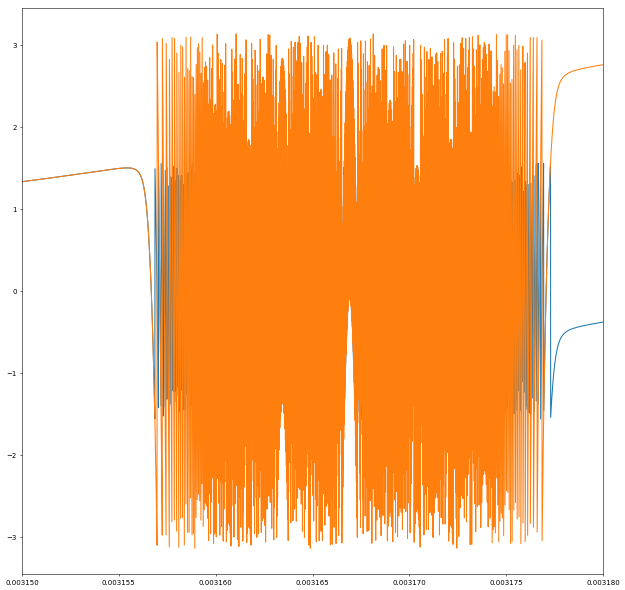

In [24]:
fig1=plt.figure(figsize=(15,15),dpi=50)
#plt.plot(xs,hfgas1.imag[0:Ng//2]/hfgas1.real[0:Ng//2])
angt=(np.arctan2(hfgas1.imag,hfgas1.real))[0:Ng//2]
plt.plot(xs,np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2])
plt.plot(xs,angt)
#plt.plot(xs,hfgas_angle)
#plt.axvline(fivac)
#plt.axvline(ffvac)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0.00315,0.00318)
plt.show()

In [13]:
np.info(np.arctan2)

arctan2(x1, x2[, out])

Element-wise arc tangent of ``x1/x2`` choosing the quadrant correctly.

The quadrant (i.e., branch) is chosen so that ``arctan2(x1, x2)`` is
the signed angle in radians between the ray ending at the origin and
passing through the point (1,0), and the ray ending at the origin and
passing through the point (`x2`, `x1`).  (Note the role reversal: the
"`y`-coordinate" is the first function parameter, the "`x`-coordinate"
is the second.)  By IEEE convention, this function is defined for
`x2` = +/-0 and for either or both of `x1` and `x2` = +/-inf (see
Notes for specific values).

This function is not defined for complex-valued arguments; for the
so-called argument of complex values, use `angle`.

Parameters
----------
x1 : array_like, real-valued
    `y`-coordinates.
x2 : array_like, real-valued
    `x`-coordinates. `x2` must be broadcastable to match the shape of
    `x1` or vice versa.

Returns
-------
angle : ndarray
    Array of angles in radians, in the range ``

In [12]:
anglevac=sci_interpolate.interp1d(xs,hfvac_angle)

In [13]:
d=(np.array((fivac,figas)).max(),np.array((ffvac,ffgas)).min())
d

(0.0031594569861234725, 0.003174349504985235)

In [14]:
A=np.sqrt(sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas))
A

/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


array([ 1.71500081,  0.15433692])

In [15]:
B=np.sqrt(sci_integrate.quad(lambda x:4*np.power(hvacs(x),2.0)/S_n_lisa(x),fivac,ffvac))
B

array([ 13.79709092,   0.65170391])

In [16]:
AB=np.sqrt(sci_integrate.quad(lambda x:4*hvacs(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)),d[0],d[1]))
AB,AB[0]/A[0]/B[0],abs(1/A[0]/B[0]*AB[1])+abs(1/A[0]/A[0]/B[0]*A[1])+abs(1/A[0]/B[0]/B[0]*B[1])

(array([ 3.548127 ,  1.7355552]), 0.1499502871374134, 0.079147183880460367)

In [17]:
mcnum=10
phinum=10
tcnum=20
mcs=np.linspace(41.5,42.5,mcnum)
phis=np.linspace(0,2*sciconsts.pi,phinum)
data=np.zeros((mcnum,phinum,tcnum,5))#(m1,phi,tc,ff,err)

In [100]:
#主循环模块
mcn=0
while mcn<mcnum:
    m1v=mcs[mcn]*m_sun
    m2v=mcs[mcn]*m_sun
    tcl=tlimit(chirp_mass(m1v,m2v),figas,ffgas)
    tcl_sp=np.linspace(tcl[0],tcl[1],tcnum)
    phin=0
    while phin<phinum:
        tcn=0
        phi_c=phis[phin]
        while tcn<tcnum:
            fivac=freq_tvac(0,m1v,m2v,tcl_sp[tcn])
            ffvac=freq_tvac(4*years,m1v,m2v,tcl_sp[tcn])
            Ng=int(t_scale*ffvac*4)
            Ng=pow2(Ng)
            T=t_scale/Ng
            xs=np.linspace(0,1/2.0/T,num=Ng//2)
            t=np.linspace(0,t_scale,num=Ng)
            hvt=hvac(t,m1v,m2v,tcl_sp[tcn],phi_c)
            hfvac1=fft.fft(hvt)
            hfvac_abs=abs(hfvac1)
            hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
            anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
            hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
            hvacs=sci_interpolate.interp1d(xs,hfvac2)
            d=(np.array((fivac,figas)).max(),np.array((ffvac,ffgas)).min())
            B=np.sqrt(sci_integrate.quad(lambda x:4*np.power(hvacs(x),2.0)/S_n_lisa(x),fivac,ffvac))
            AB=np.sqrt(sci_integrate.quad(lambda x:4*hvacs(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)),d[0],d[1]))
            data[mcn,phin,tcn,0]=mcs[mcn]
            data[mcn,phin,tcn,1]=phis[phin]
            data[mcn,phin,tcn,2]=tcl_sp[tcn]
            data[mcn,phin,tcn,3]=AB[0]/A[0]/B[0]
            data[mcn,phin,tcn,4]=abs(1/A[0]/B[0]*AB[1])+abs(1/A[0]/A[0]/B[0]*A[1])+abs(1/A[0]/B[0]/B[0]*B[1])
            print data[mcn,phin,tcn,:]
            tcn=tcn+1
        phin=phin+1
    mcn=mcn+1

/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


[  4.15000000e+01   0.00000000e+00   7.50655374e+09              nan
   5.21805576e-03]
[  4.15000000e+01   0.00000000e+00   7.52018951e+09   4.09526375e-02
   1.66123815e-02]
[  4.15000000e+01   0.00000000e+00   7.53382529e+09   5.92182095e-02
   5.15146344e-02]
[  4.15000000e+01   0.00000000e+00   7.54746107e+09   7.50480475e-02
   5.94795732e-02]
[  4.15000000e+01   0.00000000e+00   7.56109685e+09   8.54195730e-02
   5.13016825e-02]
[  4.15000000e+01   0.00000000e+00   7.57473263e+09   9.75117803e-02
   4.08143771e-02]
[  4.15000000e+01   0.00000000e+00   7.58836840e+09   1.01612195e-01
   2.23723130e-02]
[  4.15000000e+01   0.00000000e+00   7.60200418e+09   1.16087253e-01
   3.73836068e-02]
[  4.15000000e+01   0.00000000e+00   7.61563996e+09   1.19975832e-01
   8.23562790e-02]
[  4.15000000e+01   0.00000000e+00   7.62927574e+09   1.30789728e-01
   8.50939763e-02]
[  4.15000000e+01   0.00000000e+00   7.64291151e+09   1.31476047e-01
   9.87684881e-02]
[  4.15000000e+01   0.00000000e+

[  4.15000000e+01   2.79252680e+00   7.69745463e+09   9.66602873e-02
   5.94316736e-02]
[  4.15000000e+01   2.79252680e+00   7.71109040e+09   9.16606166e-02
   2.44568133e-02]
[  4.15000000e+01   2.79252680e+00   7.72472618e+09   7.75437536e-02
   4.74821506e-02]
[  4.15000000e+01   2.79252680e+00   7.73836196e+09   6.26249617e-02
   4.93894020e-02]
[  4.15000000e+01   2.79252680e+00   7.75199774e+09   3.81186540e-02
   2.88041740e-02]
[  4.15000000e+01   2.79252680e+00   7.76563352e+09              nan
   3.67724465e-03]
[  4.15000000e+01   3.49065850e+00   7.50655374e+09   5.26225410e-08
   5.23196856e-03]
[  4.15000000e+01   3.49065850e+00   7.52018951e+09   3.96604514e-02
   2.78966496e-02]
[  4.15000000e+01   3.49065850e+00   7.53382529e+09   6.54059313e-02
   4.86573143e-02]
[  4.15000000e+01   3.49065850e+00   7.54746107e+09   7.05300318e-02
   3.64731371e-02]
[  4.15000000e+01   3.49065850e+00   7.56109685e+09   8.56087447e-02
   4.52062770e-02]
[  4.15000000e+01   3.49065850e+

[  4.15000000e+01   6.28318531e+00   7.61563996e+09   1.19975832e-01
   8.23562788e-02]
[  4.15000000e+01   6.28318531e+00   7.62927574e+09   1.30789728e-01
   8.50939761e-02]
[  4.15000000e+01   6.28318531e+00   7.64291151e+09   1.31476047e-01
   9.87684880e-02]
[  4.15000000e+01   6.28318531e+00   7.65654729e+09   1.19400496e-01
   5.26233964e-02]
[  4.15000000e+01   6.28318531e+00   7.67018307e+09   1.12925509e-01
   5.97601587e-02]
[  4.15000000e+01   6.28318531e+00   7.68381885e+09   1.05968094e-01
   4.40177190e-02]
[  4.15000000e+01   6.28318531e+00   7.69745463e+09   9.68500981e-02
   4.96060830e-02]
[  4.15000000e+01   6.28318531e+00   7.71109040e+09   9.14407742e-02
   6.66925959e-02]
[  4.15000000e+01   6.28318531e+00   7.72472618e+09   7.53235024e-02
   3.15576850e-02]
[  4.15000000e+01   6.28318531e+00   7.73836196e+09   6.16277593e-02
   3.12211707e-02]
[  4.15000000e+01   6.28318531e+00   7.75199774e+09   3.88195059e-02
   3.51944776e-02]
[  4.15000000e+01   6.28318531e+

[  4.16111111e+01   2.79252680e+00   7.50038581e+09   5.85351880e-02
   3.02886365e-02]
[  4.16111111e+01   2.79252680e+00   7.51399048e+09   7.65757786e-02
   3.91769717e-02]
[  4.16111111e+01   2.79252680e+00   7.52759515e+09   8.72079428e-02
   2.92801522e-02]
[  4.16111111e+01   2.79252680e+00   7.54119982e+09   9.67928084e-02
   5.29602113e-02]
[  4.16111111e+01   2.79252680e+00   7.55480448e+09   1.02702960e-01
   4.80816164e-02]
[  4.16111111e+01   2.79252680e+00   7.56840915e+09   1.16842443e-01
   7.52666738e-02]
[  4.16111111e+01   2.79252680e+00   7.58201382e+09   1.26319779e-01
   9.37118610e-02]
[  4.16111111e+01   2.79252680e+00   7.59561849e+09   1.22024089e-01
   8.46345354e-02]
[  4.16111111e+01   2.79252680e+00   7.60922316e+09   1.27888939e-01
   6.64775357e-02]
[  4.16111111e+01   2.79252680e+00   7.62282782e+09   1.26256363e-01
   9.71144597e-02]
[  4.16111111e+01   2.79252680e+00   7.63643249e+09   1.23040499e-01
   9.47592271e-02]
[  4.16111111e+01   2.79252680e+

[  4.16111111e+01   5.58505361e+00   7.69085116e+09   7.70249589e-02
   3.49516417e-02]
[  4.16111111e+01   5.58505361e+00   7.70445583e+09   6.02773725e-02
   2.24123551e-02]
[  4.16111111e+01   5.58505361e+00   7.71806050e+09   3.87708248e-02
   3.31078266e-02]
[  4.16111111e+01   5.58505361e+00   7.73166517e+09   4.42856938e-08
   3.91149537e-03]
[  4.16111111e+01   6.28318531e+00   7.47317648e+09              nan
   4.72504769e-03]
[  4.16111111e+01   6.28318531e+00   7.48678114e+09   3.69666128e-02
   2.55567539e-02]
[  4.16111111e+01   6.28318531e+00   7.50038581e+09   6.01244071e-02
   3.35387462e-02]
[  4.16111111e+01   6.28318531e+00   7.51399048e+09   7.53806588e-02
   3.75990310e-02]
[  4.16111111e+01   6.28318531e+00   7.52759515e+09   8.87984384e-02
   3.31554448e-02]
[  4.16111111e+01   6.28318531e+00   7.54119982e+09   9.86261133e-02
   3.75838107e-02]
[  4.16111111e+01   6.28318531e+00   7.55480448e+09   1.03261818e-01
   5.24559795e-02]
[  4.16111111e+01   6.28318531e+

[  4.17222222e+01   2.09439510e+00   7.57577383e+09   1.29652845e-01
   4.82368954e-02]
[  4.17222222e+01   2.09439510e+00   7.58934761e+09   1.27097730e-01
   6.85840572e-02]
[  4.17222222e+01   2.09439510e+00   7.60292138e+09   1.18710154e-01
   9.04053246e-02]
[  4.17222222e+01   2.09439510e+00   7.61649516e+09   1.05131899e-01
   2.41012562e-02]
[  4.17222222e+01   2.09439510e+00   7.63006894e+09   9.58791996e-02
   7.19696647e-02]
[  4.17222222e+01   2.09439510e+00   7.64364272e+09   8.71055135e-02
   4.89650651e-02]
[  4.17222222e+01   2.09439510e+00   7.65721650e+09   7.77897096e-02
   6.02929059e-02]
[  4.17222222e+01   2.09439510e+00   7.67079028e+09   6.04365481e-02
   3.27466864e-02]
[  4.17222222e+01   2.09439510e+00   7.68436406e+09   3.88839271e-02
   2.73396883e-02]
[  4.17222222e+01   2.09439510e+00   7.69793784e+09   3.86896796e-08
   4.14354736e-03]
[  4.17222222e+01   2.79252680e+00   7.44003604e+09   2.86548586e-08
   5.49317937e-03]
[  4.17222222e+01   2.79252680e+

[  4.17222222e+01   5.58505361e+00   7.49433115e+09   8.98259012e-02
   2.59246518e-02]
[  4.17222222e+01   5.58505361e+00   7.50790493e+09   1.00577292e-01
   7.67592349e-02]
[  4.17222222e+01   5.58505361e+00   7.52147871e+09   1.05267997e-01
   2.90135069e-02]
[  4.17222222e+01   5.58505361e+00   7.53505249e+09   1.10575475e-01
   5.63172751e-02]
[  4.17222222e+01   5.58505361e+00   7.54862627e+09   1.19287407e-01
   5.58905564e-02]
[  4.17222222e+01   5.58505361e+00   7.56220005e+09   1.32033122e-01
   5.23382518e-02]
[  4.17222222e+01   5.58505361e+00   7.57577383e+09   1.35139254e-01
   1.04298244e-01]
[  4.17222222e+01   5.58505361e+00   7.58934761e+09   1.26442429e-01
   5.65304399e-02]
[  4.17222222e+01   5.58505361e+00   7.60292138e+09   1.14391492e-01
   2.17686680e-02]
[  4.17222222e+01   5.58505361e+00   7.61649516e+09   1.05973643e-01
   4.97642226e-02]
[  4.17222222e+01   5.58505361e+00   7.63006894e+09   9.91857071e-02
   7.73352387e-02]
[  4.17222222e+01   5.58505361e+

[  4.18333333e+01   1.39626340e+00   7.65090607e+09   3.95914386e-02
   3.20097152e-02]
[  4.18333333e+01   1.39626340e+00   7.66444918e+09              nan
   4.77835314e-03]
[  4.18333333e+01   2.09439510e+00   7.40713012e+09              nan
   4.02180191e-03]
[  4.18333333e+01   2.09439510e+00   7.42067323e+09   3.75147152e-02
   2.72475080e-02]
[  4.18333333e+01   2.09439510e+00   7.43421634e+09   5.93657388e-02
   2.42621705e-02]
[  4.18333333e+01   2.09439510e+00   7.44775944e+09   7.77197020e-02
   5.95372737e-02]
[  4.18333333e+01   2.09439510e+00   7.46130255e+09   8.90988863e-02
   4.77518009e-02]
[  4.18333333e+01   2.09439510e+00   7.47484566e+09   9.58794659e-02
   2.28435976e-02]
[  4.18333333e+01   2.09439510e+00   7.48838877e+09   1.06402817e-01
   4.42023552e-02]
[  4.18333333e+01   2.09439510e+00   7.50193188e+09   1.13652769e-01
   9.26925353e-02]
[  4.18333333e+01   2.09439510e+00   7.51547499e+09   1.27759508e-01
   9.44006402e-02]
[  4.18333333e+01   2.09439510e+

[  4.18333333e+01   4.88692191e+00   7.56964742e+09   1.16790743e-01
   4.29246628e-02]
[  4.18333333e+01   4.88692191e+00   7.58319053e+09   1.06009611e-01
   6.05637088e-02]
[  4.18333333e+01   4.88692191e+00   7.59673364e+09   9.10566786e-02
   5.06173171e-02]
[  4.18333333e+01   4.88692191e+00   7.61027674e+09   8.78583664e-02
   7.56523357e-03]
[  4.18333333e+01   4.88692191e+00   7.62381985e+09   7.47297416e-02
   3.75917350e-02]
[  4.18333333e+01   4.88692191e+00   7.63736296e+09   6.01437031e-02
   5.41440129e-02]
[  4.18333333e+01   4.88692191e+00   7.65090607e+09   3.90848821e-02
   3.52947967e-02]
[  4.18333333e+01   4.88692191e+00   7.66444918e+09              nan
   4.77858855e-03]
[  4.18333333e+01   5.58505361e+00   7.40713012e+09              nan
   4.02224857e-03]
[  4.18333333e+01   5.58505361e+00   7.42067323e+09   3.92030955e-02
   1.48827773e-02]
[  4.18333333e+01   5.58505361e+00   7.43421634e+09   5.98654335e-02
   1.41275199e-02]
[  4.18333333e+01   5.58505361e+

[  4.19444444e+01   1.39626340e+00   7.45553237e+09   1.02750840e-01
   7.22434566e-02]
[  4.19444444e+01   1.39626340e+00   7.46904502e+09   1.13016330e-01
   5.59875903e-02]
[  4.19444444e+01   1.39626340e+00   7.48255768e+09   1.24630549e-01
   5.28060212e-02]
[  4.19444444e+01   1.39626340e+00   7.49607033e+09   1.34568654e-01
   7.36127504e-02]
[  4.19444444e+01   1.39626340e+00   7.50958299e+09   1.31875371e-01
   1.05362046e-01]
[  4.19444444e+01   1.39626340e+00   7.52309564e+09   1.27031487e-01
   7.34232754e-02]
[  4.19444444e+01   1.39626340e+00   7.53660829e+09   1.19253425e-01
   8.78900824e-02]
[  4.19444444e+01   1.39626340e+00   7.55012095e+09   1.03172887e-01
   4.46107383e-02]
[  4.19444444e+01   1.39626340e+00   7.56363360e+09   9.81066013e-02
   3.00351686e-02]
[  4.19444444e+01   1.39626340e+00   7.57714626e+09   9.02841688e-02
   3.12188804e-02]
[  4.19444444e+01   1.39626340e+00   7.59065891e+09   7.61355259e-02
   4.04031036e-02]
[  4.19444444e+01   1.39626340e+

[  4.19444444e+01   4.88692191e+00   7.37445644e+09              nan
   4.54037792e-03]
[  4.19444444e+01   4.88692191e+00   7.38796910e+09   4.06791955e-02
   2.04140355e-02]
[  4.19444444e+01   4.88692191e+00   7.40148175e+09   5.90756464e-02
   2.19170915e-02]
[  4.19444444e+01   4.88692191e+00   7.41499441e+09   7.45307127e-02
   5.01145844e-02]
[  4.19444444e+01   4.88692191e+00   7.42850706e+09   8.69284994e-02
   6.51552769e-02]
[  4.19444444e+01   4.88692191e+00   7.44201971e+09   9.84908516e-02
   7.75799916e-02]
[  4.19444444e+01   4.88692191e+00   7.45553237e+09   1.07423075e-01
   8.32385417e-02]
[  4.19444444e+01   4.88692191e+00   7.46904502e+09   1.14845492e-01
   9.11874894e-02]
[  4.19444444e+01   4.88692191e+00   7.48255768e+09   1.29984765e-01
   4.55525685e-02]
[  4.19444444e+01   4.88692191e+00   7.49607033e+09   1.32574051e-01
   6.89869998e-02]
[  4.19444444e+01   4.88692191e+00   7.50958299e+09   1.31129555e-01
   1.42389179e-02]
[  4.19444444e+01   4.88692191e+

[  4.20555556e+01   6.98131701e-01   7.53076656e+09   9.76199411e-02
   5.97605858e-02]
[  4.20555556e+01   6.98131701e-01   7.54424898e+09   8.66239049e-02
   5.49264742e-02]
[  4.20555556e+01   6.98131701e-01   7.55773139e+09   7.75582572e-02
   5.95748691e-02]
[  4.20555556e+01   6.98131701e-01   7.57121381e+09   6.28656028e-02
   4.20461443e-02]
[  4.20555556e+01   6.98131701e-01   7.58469622e+09   3.81959569e-02
   2.15686896e-02]
[  4.20555556e+01   6.98131701e-01   7.59817864e+09              nan
   4.59931496e-03]
[  4.20555556e+01   1.39626340e+00   7.34201276e+09   5.27269681e-08
   5.07541037e-03]
[  4.20555556e+01   1.39626340e+00   7.35549518e+09   3.87767916e-02
   1.85409503e-02]
[  4.20555556e+01   1.39626340e+00   7.36897759e+09   5.66116370e-02
   2.20750921e-02]
[  4.20555556e+01   1.39626340e+00   7.38246000e+09   7.38312213e-02
   3.57372812e-02]
[  4.20555556e+01   1.39626340e+00   7.39594242e+09   8.83318751e-02
   3.80886991e-02]
[  4.20555556e+01   1.39626340e+

[  4.20555556e+01   4.18879020e+00   7.44987208e+09   1.19810313e-01
   7.47641118e-02]
[  4.20555556e+01   4.18879020e+00   7.46335449e+09   1.30060321e-01
   3.16829304e-02]
[  4.20555556e+01   4.18879020e+00   7.47683691e+09   1.22162040e-01
   7.75335085e-02]
[  4.20555556e+01   4.18879020e+00   7.49031932e+09   1.24222963e-01
   3.57567697e-02]
[  4.20555556e+01   4.18879020e+00   7.50380174e+09   1.06218331e-01
   8.49633481e-02]
[  4.20555556e+01   4.18879020e+00   7.51728415e+09   1.02829201e-01
   6.60001886e-02]
[  4.20555556e+01   4.18879020e+00   7.53076656e+09   9.71128256e-02
   4.69985773e-02]
[  4.20555556e+01   4.18879020e+00   7.54424898e+09   8.70623344e-02
   6.99243817e-02]
[  4.20555556e+01   4.18879020e+00   7.55773139e+09   7.67707211e-02
   3.63612887e-02]
[  4.20555556e+01   4.18879020e+00   7.57121381e+09   6.03923895e-02
   1.41909085e-02]
[  4.20555556e+01   4.18879020e+00   7.58469622e+09   3.80621015e-02
   1.90180340e-02]
[  4.20555556e+01   4.18879020e+

[  4.21666667e+01   6.98131701e-01   7.33670163e+09   5.73109081e-02
   4.40440011e-02]
[  4.21666667e+01   6.98131701e-01   7.35015402e+09   7.68511499e-02
   1.81044543e-02]
[  4.21666667e+01   6.98131701e-01   7.36360640e+09   8.65347723e-02
   3.69597312e-02]
[  4.21666667e+01   6.98131701e-01   7.37705879e+09   9.60286036e-02
   3.94627579e-02]
[  4.21666667e+01   6.98131701e-01   7.39051118e+09   1.05184389e-01
   7.05809410e-02]
[  4.21666667e+01   6.98131701e-01   7.40396356e+09   1.09919846e-01
   2.05326228e-02]
[  4.21666667e+01   6.98131701e-01   7.41741595e+09   1.26403438e-01
   4.06907753e-02]
[  4.21666667e+01   6.98131701e-01   7.43086834e+09   1.30622236e-01
   1.06168139e-01]
[  4.21666667e+01   6.98131701e-01   7.44432073e+09   1.34965056e-01
   5.20504586e-02]
[  4.21666667e+01   6.98131701e-01   7.45777311e+09   1.23559834e-01
   1.00184964e-01]
[  4.21666667e+01   6.98131701e-01   7.47122550e+09   1.13814437e-01
   5.57970353e-02]
[  4.21666667e+01   6.98131701e-

[  4.21666667e+01   3.49065850e+00   7.52503505e+09   7.71093438e-02
   6.03703839e-02]
[  4.21666667e+01   3.49065850e+00   7.53848743e+09   5.90888614e-02
   5.19805562e-02]
[  4.21666667e+01   3.49065850e+00   7.55193982e+09   4.15658864e-02
   1.65025613e-02]
[  4.21666667e+01   3.49065850e+00   7.56539221e+09              nan
   4.57103953e-03]
[  4.21666667e+01   4.18879020e+00   7.30979685e+09              nan
   6.06162724e-03]
[  4.21666667e+01   4.18879020e+00   7.32324924e+09   3.96946490e-02
   2.92990536e-02]
[  4.21666667e+01   4.18879020e+00   7.33670163e+09   5.38492412e-02
   2.32118578e-02]
[  4.21666667e+01   4.18879020e+00   7.35015402e+09   7.61058921e-02
   4.33591135e-02]
[  4.21666667e+01   4.18879020e+00   7.36360640e+09   8.39728305e-02
   5.00933314e-02]
[  4.21666667e+01   4.18879020e+00   7.37705879e+09   9.66695701e-02
   2.81953334e-02]
[  4.21666667e+01   4.18879020e+00   7.39051118e+09   1.05139668e-01
   7.61428135e-02]
[  4.21666667e+01   4.18879020e+

[  4.22777778e+01   0.00000000e+00   7.41203223e+09   1.30122785e-01
   3.71983640e-02]
[  4.22777778e+01   0.00000000e+00   7.42545480e+09   1.24728333e-01
   9.81994712e-02]
[  4.22777778e+01   0.00000000e+00   7.43887737e+09   1.15033034e-01
   2.83916195e-02]
[  4.22777778e+01   0.00000000e+00   7.45229994e+09   1.05113276e-01
   4.67566714e-02]
[  4.22777778e+01   0.00000000e+00   7.46572251e+09   9.54159595e-02
   3.99561247e-02]
[  4.22777778e+01   0.00000000e+00   7.47914508e+09   8.78654193e-02
   7.18674896e-02]
[  4.22777778e+01   0.00000000e+00   7.49256765e+09   7.60541799e-02
   1.88580172e-02]
[  4.22777778e+01   0.00000000e+00   7.50599022e+09   5.74472673e-02
   2.12828345e-02]
[  4.22777778e+01   0.00000000e+00   7.51941279e+09   4.12361190e-02
   1.74970127e-02]
[  4.22777778e+01   0.00000000e+00   7.53283536e+09   2.46941240e-08
   4.47684448e-03]
[  4.22777778e+01   6.98131701e-01   7.27780653e+09              nan
   4.91428464e-03]
[  4.22777778e+01   6.98131701e-

[  4.22777778e+01   3.49065850e+00   7.33149681e+09   8.85859859e-02
   6.88033664e-02]
[  4.22777778e+01   3.49065850e+00   7.34491938e+09   9.44800082e-02
   3.81624842e-02]
[  4.22777778e+01   3.49065850e+00   7.35834195e+09   1.04884521e-01
   3.24163169e-02]
[  4.22777778e+01   3.49065850e+00   7.37176452e+09   1.11911604e-01
   4.57992164e-02]
[  4.22777778e+01   3.49065850e+00   7.38518709e+09   1.23357243e-01
   4.56909236e-02]
[  4.22777778e+01   3.49065850e+00   7.39860966e+09   1.31935098e-01
   9.18193348e-02]
[  4.22777778e+01   3.49065850e+00   7.41203223e+09   1.31668148e-01
   1.04662222e-01]
[  4.22777778e+01   3.49065850e+00   7.42545480e+09   1.27611243e-01
   8.94428404e-02]
[  4.22777778e+01   3.49065850e+00   7.43887737e+09   1.06740608e-01
   7.75140721e-02]
[  4.22777778e+01   3.49065850e+00   7.45229994e+09   1.05150811e-01
   4.03516078e-02]
[  4.22777778e+01   3.49065850e+00   7.46572251e+09   9.61434330e-02
   5.82368008e-02]
[  4.22777778e+01   3.49065850e+

[  4.22777778e+01   6.28318531e+00   7.51941279e+09   4.12361190e-02
   1.74970127e-02]
[  4.22777778e+01   6.28318531e+00   7.53283536e+09   2.46941243e-08
   4.47684448e-03]
[  4.23888889e+01   0.00000000e+00   7.24603962e+09   5.42442781e-08
   5.58549324e-03]
[  4.23888889e+01   0.00000000e+00   7.25943258e+09   3.81161278e-02
   3.25143591e-02]
[  4.23888889e+01   0.00000000e+00   7.27282554e+09   5.91265497e-02
   4.78591205e-02]
[  4.23888889e+01   0.00000000e+00   7.28621850e+09   7.22467302e-02
   4.73888238e-02]
[  4.23888889e+01   0.00000000e+00   7.29961146e+09   8.88335532e-02
   6.63059527e-02]
[  4.23888889e+01   0.00000000e+00   7.31300442e+09   1.01922432e-01
   7.35738565e-02]
[  4.23888889e+01   0.00000000e+00   7.32639738e+09   1.03437656e-01
   5.29738301e-02]
[  4.23888889e+01   0.00000000e+00   7.33979035e+09   1.13858206e-01
   8.74289233e-02]
[  4.23888889e+01   0.00000000e+00   7.35318331e+09   1.24763420e-01
   9.51559780e-02]
[  4.23888889e+01   0.00000000e+

[  4.23888889e+01   2.79252680e+00   7.40675515e+09   1.14828831e-01
   6.37796327e-02]
[  4.23888889e+01   2.79252680e+00   7.42014811e+09   1.08355864e-01
   5.39259788e-02]
[  4.23888889e+01   2.79252680e+00   7.43354107e+09   9.65024831e-02
   4.58924356e-02]
[  4.23888889e+01   2.79252680e+00   7.44693403e+09   8.85123852e-02
   6.98857570e-02]
[  4.23888889e+01   2.79252680e+00   7.46032699e+09   7.61875035e-02
   6.02587231e-02]
[  4.23888889e+01   2.79252680e+00   7.47371996e+09   5.96579092e-02
   3.34775391e-02]
[  4.23888889e+01   2.79252680e+00   7.48711292e+09   3.89587343e-02
   2.18165288e-02]
[  4.23888889e+01   2.79252680e+00   7.50050588e+09              nan
   4.20879741e-03]
[  4.23888889e+01   3.49065850e+00   7.24603962e+09   5.22867600e-08
   5.58468325e-03]
[  4.23888889e+01   3.49065850e+00   7.25943258e+09   3.95717929e-02
   1.66579683e-02]
[  4.23888889e+01   3.49065850e+00   7.27282554e+09   5.84862650e-02
   3.52546178e-02]
[  4.23888889e+01   3.49065850e+

[  4.23888889e+01   6.28318531e+00   7.32639738e+09   1.03437656e-01
   5.29738303e-02]
[  4.23888889e+01   6.28318531e+00   7.33979035e+09   1.13858206e-01
   8.74289226e-02]
[  4.23888889e+01   6.28318531e+00   7.35318331e+09   1.24763420e-01
   9.51559782e-02]
[  4.23888889e+01   6.28318531e+00   7.36657627e+09   1.32735200e-01
   9.39390468e-02]
[  4.23888889e+01   6.28318531e+00   7.37996923e+09   1.27138899e-01
   7.71097575e-02]
[  4.23888889e+01   6.28318531e+00   7.39336219e+09   1.20201296e-01
   4.21180163e-02]
[  4.23888889e+01   6.28318531e+00   7.40675515e+09   1.07555592e-01
   7.27668126e-02]
[  4.23888889e+01   6.28318531e+00   7.42014811e+09   1.01650582e-01
   3.91635618e-02]
[  4.23888889e+01   6.28318531e+00   7.43354107e+09   9.82374038e-02
   7.41530778e-02]
[  4.23888889e+01   6.28318531e+00   7.44693403e+09   8.83691980e-02
   2.81041416e-02]
[  4.23888889e+01   6.28318531e+00   7.46032699e+09   7.61837514e-02
   6.15142180e-02]
[  4.23888889e+01   6.28318531e+

[  4.25000000e+01   2.79252680e+00   7.21449398e+09              nan
   4.98120849e-03]
[  4.25000000e+01   2.79252680e+00   7.22785754e+09   3.86876890e-02
   3.20811234e-02]
[  4.25000000e+01   2.79252680e+00   7.24122110e+09   5.87673052e-02
   3.85315911e-02]
[  4.25000000e+01   2.79252680e+00   7.25458466e+09   7.69379142e-02
   5.10866553e-02]
[  4.25000000e+01   2.79252680e+00   7.26794822e+09   8.26722134e-02
   3.67850891e-02]
[  4.25000000e+01   2.79252680e+00   7.28131178e+09   9.65891658e-02
   4.89947420e-02]
[  4.25000000e+01   2.79252680e+00   7.29467533e+09   1.07104703e-01
   8.13942353e-02]
[  4.25000000e+01   2.79252680e+00   7.30803889e+09   1.03114326e-01
   8.02965988e-02]
[  4.25000000e+01   2.79252680e+00   7.32140245e+09   1.17623201e-01
   3.75394644e-02]
[  4.25000000e+01   2.79252680e+00   7.33476601e+09   1.29776180e-01
   2.43179863e-02]
[  4.25000000e+01   2.79252680e+00   7.34812957e+09   1.33209830e-01
   1.00670399e-01]
[  4.25000000e+01   2.79252680e+

[  4.25000000e+01   5.58505361e+00   7.40158380e+09   9.66076266e-02
   3.48443738e-02]
[  4.25000000e+01   5.58505361e+00   7.41494736e+09   8.96459852e-02
   3.48025239e-02]
[  4.25000000e+01   5.58505361e+00   7.42831092e+09   7.63673486e-02
   4.19960479e-02]
[  4.25000000e+01   5.58505361e+00   7.44167448e+09   5.94955468e-02
   4.98704590e-02]
[  4.25000000e+01   5.58505361e+00   7.45503803e+09   4.08826296e-02
   1.80453326e-02]
[  4.25000000e+01   5.58505361e+00   7.46840159e+09              nan
   3.87548968e-03]
[  4.25000000e+01   6.28318531e+00   7.21449398e+09              nan
   4.98157438e-03]
[  4.25000000e+01   6.28318531e+00   7.22785754e+09   3.76363306e-02
   2.36162769e-02]
[  4.25000000e+01   6.28318531e+00   7.24122110e+09   5.81896340e-02
   5.08904314e-02]
[  4.25000000e+01   6.28318531e+00   7.25458466e+09   7.25378985e-02
   3.80741058e-02]
[  4.25000000e+01   6.28318531e+00   7.26794822e+09   8.63162502e-02
   4.75549855e-02]
[  4.25000000e+01   6.28318531e+

In [103]:
data[1,:,:,:].max()

nan

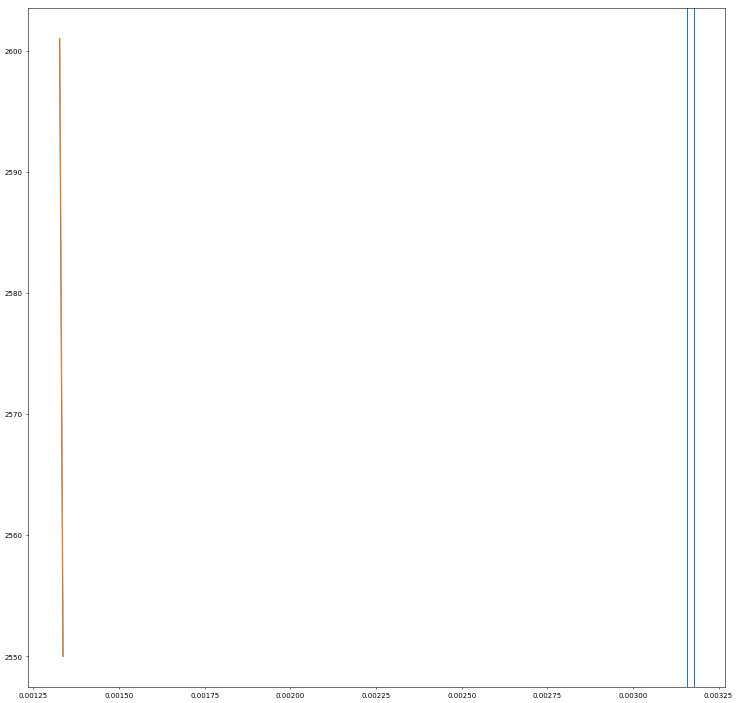

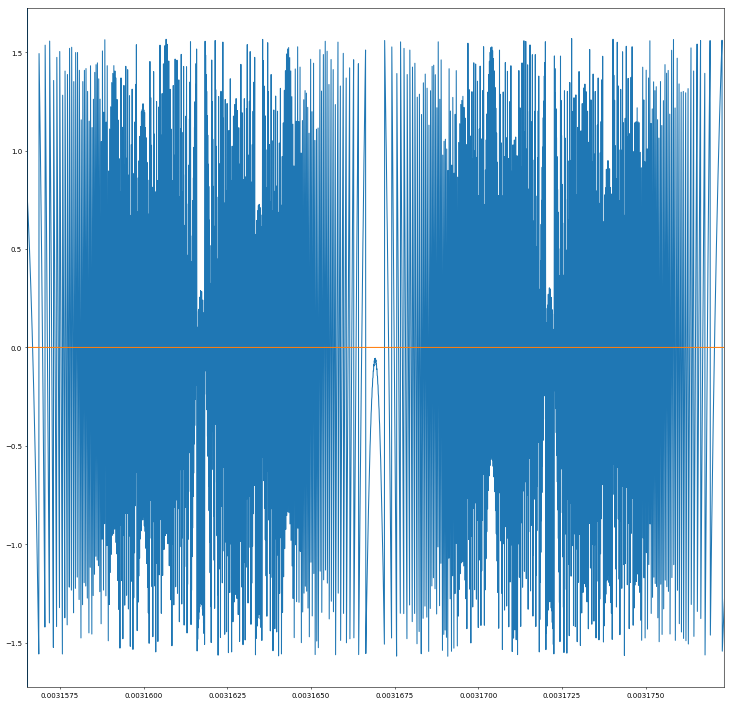

In [13]:
fig1=plt.figure(figsize=(18,18),dpi=50)
f2=np.linspace(0,1/2.0/T,10000)
plt.plot(xs,hfgas_angle)
plt.plot(xs,hfgas2*1e8)
plt.axvline(figas)
plt.axvline(ffgas)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(figas,ffgas)
plt.show()

In [14]:
fig1=plt.figure(figsize=(18,18),dpi=50)
f2=np.linspace(0,1/2.0/T,1000000)
plt.plot(xs,hfvac_angle)
plt.plot(xs,hfvac2*1e8)
#plt.axvline(fivac)
#plt.axvline(ffvac)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(fivac,ffvac)
plt.show()

NameError: name 'hfvac_angle' is not defined

In [155]:
d=(np.array((fivac,figas)).min(),np.array((ffvac,ffgas)).max())

(0.003156510626997829, 0.0031773580608164547)

In [ ]:
fig1=plt.figure(figsize=(18,18),dpi=50)
plt.plot(xs,hfgas2)
plt.plot(xs,hfvac2)
#plt.axvline(fivac)
#plt.axvline(ffvac)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(np.array((fivac,figas)).min(),np.array((ffvac,ffgas)).max())
plt.show()

In [130]:
f3=np.linspace(0.0001,0.01,num=40000)
work4=np.zeros(40000)
work5=np.zeros(40000)
i=0
while i<40000:
    #work1[i]=phi_t(t[i],m_1,m_2,t_gas,t_0)%(2*sciconsts.pi)
    #print phi_t(t[i],m_1,m_2,t_gas,t_0)
    #work2[i]=phi_h_f_gas(f[i],m_1,m_2,t_gas,t_0)%(2*sciconsts.pi)
    #work3[i]=abs(h_f(f[i],m_1,m_2,t_gas,t_0))
    work4[i]=np.arctan(h_fgas(f3[i],m_1,m_2,t_gas,t_0).imag/h_fgas(f3[i],m_1,m_2,t_gas,t_0).real)
    work5[i]=phif(f3[i],m_1,m_2,t_gas,t_0)
    i=i+1


In [103]:
freq_ana(hfgas2,N/2)

((0.0031567969939117198, 2.8958140241730777e-08),
 (0.003177075405885337, 2.8787015095505297e-08))

In [47]:
tphi=np.linspace(0,t_scale,10000)
i=0
workphi=np.zeros(10000)
while i<10000:
    workphi[i]=phi_tgas(tphi[i],m_1,m_2,t_gas,t_0)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)

In [110]:
a=solvem(35.73*m_sun,0.15)
a[0]/m_sun,a[1]/m_sun

(91.031065285182663, 20.495482910317936)

In [111]:
work3.size

10000000

In [52]:
f_jugg(1000*years,m_1g,m_2g)

(0.0045142329442214475, 0.004521022974015557)

In [56]:
help(plt.annotate)

Help on function annotate in module matplotlib.pyplot:

annotate(*args, **kwargs)
    Annotate the point ``xy`` with text ``s``.
    
    Additional kwargs are passed to `~matplotlib.text.Text`.
    
    Parameters
    ----------
    
    s : str
        The text of the annotation
    
    xy : iterable
        Length 2 sequence specifying the *(x,y)* point to annotate
    
    xytext : iterable, optional
        Length 2 sequence specifying the *(x,y)* to place the text
        at.  If None, defaults to ``xy``.
    
    xycoords : str, Artist, Transform, callable or tuple, optional
    
        The coordinate system that ``xy`` is given in.
    
        For a `str` the allowed values are:
    
        =================   ===============================================
        Property            Description
        =================   ===============================================
        'figure points'     points from the lower left of the figure
        'figure pixels'     pixels 

In [82]:
mc=np.linspace(23.1*m_sun,23.3*m_sun,10)
noden_cal(mc,20,0.0001,figas,ffgas)

19120.0

43.0761883124


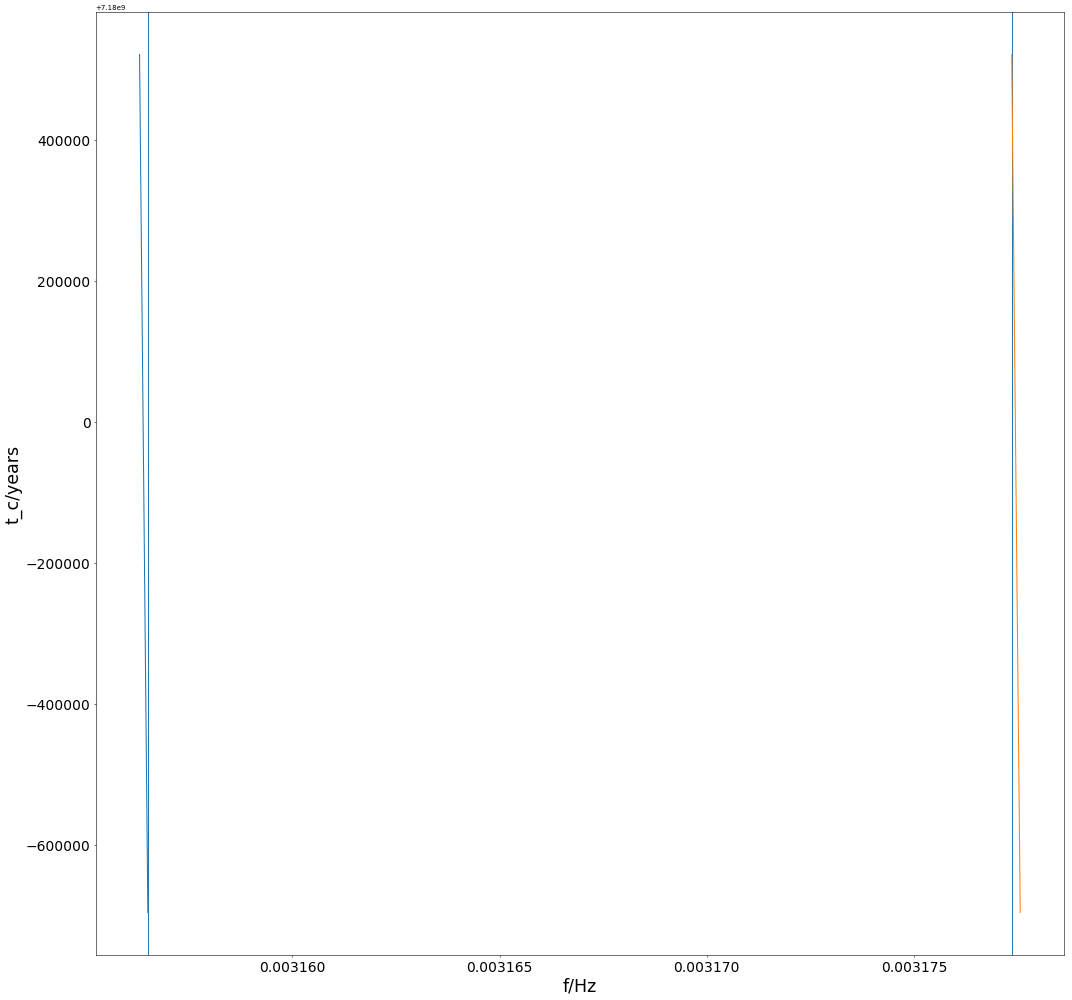

In [33]:
n=37.5
mc1=n*m_sun
m1=solvem(mc1,0.25)
print m1[0]/m_sun
fig1=plt.figure(figsize=(25,25),dpi=50)
tfj=np.linspace(tlimit(mc1,figas,ffgas)[0],tlimit(mc1,figas,ffgas)[1],10000)
plt.ylabel('t_c/years',fontsize=25)
plt.xlabel('f/Hz',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

yfj=f_jugg(tfj,m1[0],m1[1])
#print ((tlimit(mc1,figas,ffgas)[1]-tlimit(chirp_mass(n*m_sun,n*m_sun),figas,ffgas)[0])/tlimit(mc1,figas,ffgas)[1])//0.0001+1
plt.axvline(figas)
plt.axvline(ffgas)
plt.plot(yfj[0],tfj)
plt.plot(yfj[1],tfj)
#plt.plot(fint,work10/years)
#plt.plot(yfj[1]-yfj[0],tfj)
#plt.xscale('log')
plt.show()

In [83]:
np.where(yfj[0]>=figas)

(array([   0,    1,    2, ..., 3988, 3989, 3990]),)

In [84]:
np.where(yfj[0]<=ffgas)

(array([3878, 3879, 3880, ..., 9997, 9998, 9999]),)

In [85]:
tfj[3878],tfj[3990]

(2551.3551355135514, 2596.159615961596)

In [16]:
tlimit(chirp_mass(40*m_sun,40*m_sun),figas,ffgas)

(7981553704.0487261, 8249045399.3651037)

In [106]:
80449020180.779083/years

2551.021695230184

In [107]:
81999859674.244934/years

2600.198492968193

504576000.0

8388608

In [73]:
np.power(11,0.6)*chirp_mass(10*m_sun,10*m_sun)

7.2993843041193417e+31

In [76]:
solvem(7.2993843041193417e+31,0.25)

(8.3847907426330651e+31, 8.3847907426330651e+31)

In [77]:
8.3847907426330651e+31/m_sun

42.15369133091883

In [101]:
nan

NameError: name 'nan' is not defined

In [37]:
chirp_mass(n*m_sun,n*m_sun)/m_sun

36.911343883755507

In [36]:
np.arctan(500)/sciconsts.pi

0.49936338107645672

In [4]:
177542566.899/10/sciconsts.c

0.05922182568682231

In [20]:
a=m_sun*m_sun*4/a_0/10/mpc*np.power(sciconsts.G,2.0)/np.power(sciconsts.c,4.0)

In [31]:
np.sqrt(4*a*a*4*years/1.9022102881418837e-40)

0.15357146905653699

In [25]:
a*a*4*years/2.0847433818625607e-05/1.9022102881418837e-40*2.0847433818625607e-05

0.0058960490270457237

In [23]:
S_n_lisa(0.00316)

NameError: name 'S_n_lisa' is not defined

In [26]:
10*m_sun

1.9891e+31

In [27]:
10*mpc

3.085144207108599e+23